In [1]:
import os
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Cargar los datos de las imágenes y las etiquetas en ./imgs/SNR_high y transformarlos
# Definir la ruta al conjunto de datos
dataset_path = 'imgs/SNR_high'

# Inicializar listas para almacenar imágenes y etiquetas
images = []
labels = []

# Definir el tamaño de la imagen
image_size = (50, 50)

# Cargar imágenes y etiquetas
for filename in os.listdir(dataset_path):
    if filename.endswith('.png'):
        # Cargar imagen
        img = imread(os.path.join(dataset_path, filename), as_gray=True)
        img_resized = resize(img, image_size, anti_aliasing=True)
        images.append(img_resized)
        # Extraer la etiqueta del nombre de archivo
        label = filename.split('_')[0]
        labels.append(label)

# Convertir listas a arrays de numpy
X = np.array(images)
y = np.array(labels)

# Redimensionar X para añadir la dimensión del canal
X = X.reshape(X.shape[0], image_size[0], image_size[1], 1)

print(f'Cargadas {X.shape[0]} imágenes con forma {X.shape[1:]}')
print(f'Etiquetas: {np.unique(y)}')

# Aleatorizar la posición de las imágenes y sus etiquetas
X_shuffled, y_shuffled = shuffle(X, y, random_state=42)

# Convertir las etiquetas (str) a enteros y a formato categórico
labels_unique = np.unique(y_shuffled)
label_to_int = {label: idx for idx, label in enumerate(labels_unique)}
y_int = np.array([label_to_int[label] for label in y_shuffled])
y_cat = to_categorical(y_int, num_classes=len(labels_unique))

# Partición de los datos en entrenamiento (80%) y validación (20%)
X_train, X_val, y_train, y_val = train_test_split(X_shuffled, y_cat, test_size=0.2, random_state=42)

Cargadas 500 imágenes con forma (50, 50, 1)
Etiquetas: ['3j9i' '4cr2' '4v4r' '4v94' '6utj']


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 7744)              0         
                                                                 
 dense (Dense)               (None, 128)               9

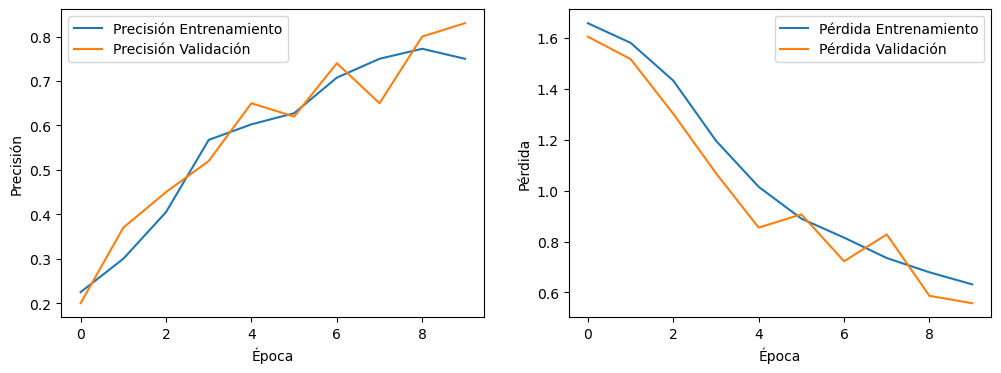

4/4 [==============================] - 1s 80ms/step


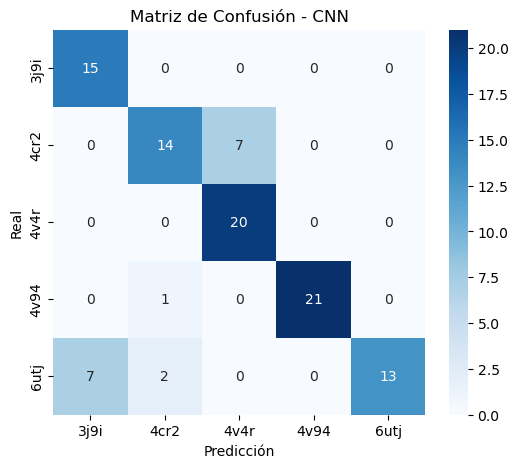

In [3]:
# Construir CNN
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X.shape[1:]),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(labels_unique), activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Mostrar el resumen para comparar el número de parámetros con el MLP (el número de parámetros es menor ahora)
model_cnn.summary()

# Entrenar el modelo CNN
history_cnn = model_cnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
loss_cnn, accuracy_cnn = model_cnn.evaluate(X_val, y_val, verbose=0)
print(f'Precisión Validación CNN: {accuracy_cnn*100:.2f}%')

# Gráfica de la precisión y pérdida en el conjunto de entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Precisión Entrenamiento')
plt.plot(history_cnn.history['val_accuracy'], label='Precisión Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Pérdida Entrenamiento')
plt.plot(history_cnn.history['val_loss'], label='Pérdida Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Mostrar la matriz de confusión usando el conjunto de validación
y_pred = model_cnn.predict(X_val)
y_pred_class = y_pred.argmax(axis=1)
y_true = y_val.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred_class)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_unique, yticklabels=labels_unique)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - CNN')
plt.show()

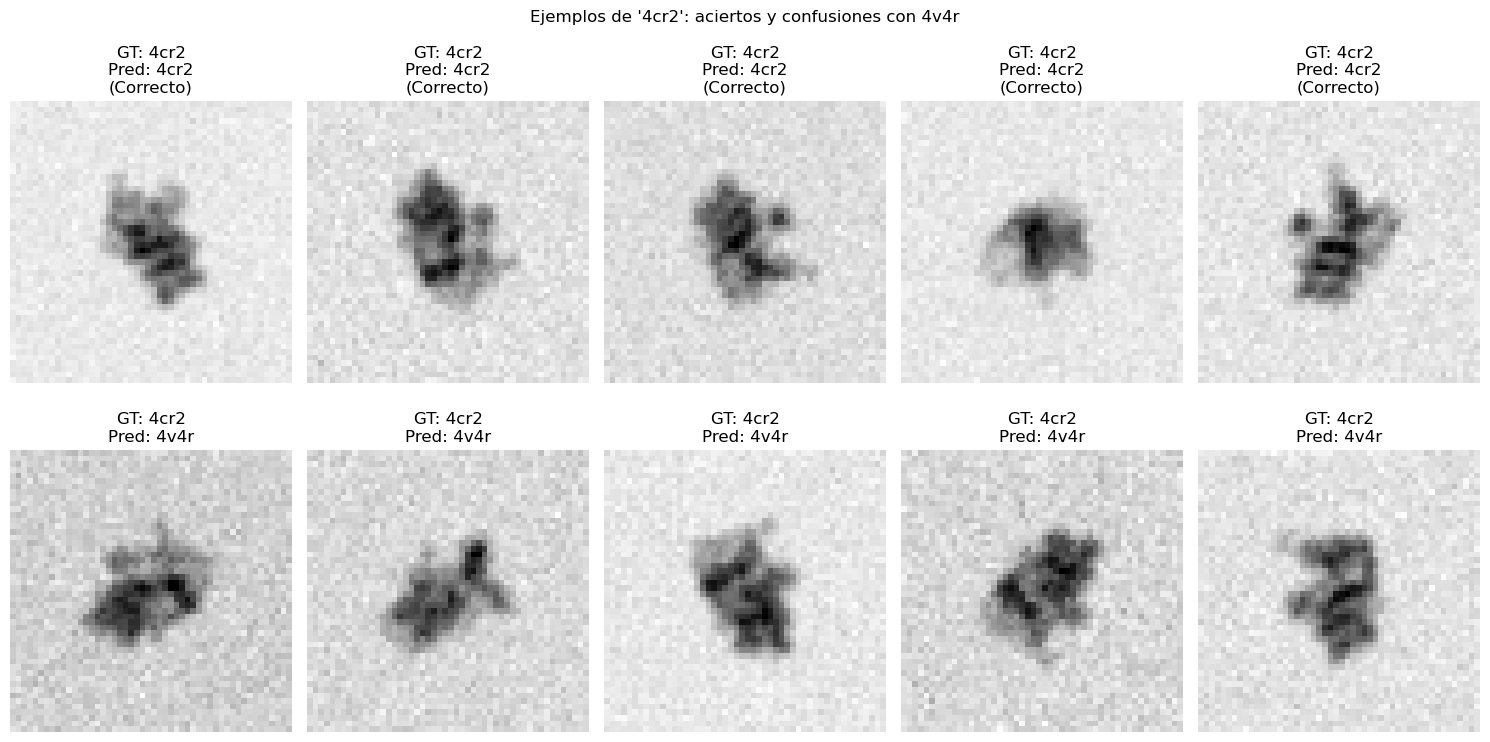

In [ ]:
# Celda para graficar ejemplos de aciertos y confusiones
# Seleccionar la clase objetivo y las clases con las que se confunde
target_label = '4cr2'
confused_with = ['4v4r']
target_idx = label_to_int[target_label]
confused_with_idxs = [label_to_int[lbl] for lbl in confused_with]

# Buscar índices en el conjunto de validación donde la etiqueta real es la correspondiente
target_val_indices = np.where(y_true == target_idx)[0]

# Separar ejemplos en los que la predicción es correcta versus cuando se confunde
correct_idxs = [idx for idx in target_val_indices if y_pred_class[idx] == target_idx]
misclassified_idxs = [idx for idx in target_val_indices if y_pred_class[idx] in confused_with_idxs]

# Creamos una disposición con una fila para las predicciones correctas 
# y una fila adicional por cada etiqueta en confused_with
num_examples = 5
n_confused = len(confused_with)
fig, axes = plt.subplots(1 + n_confused, num_examples, figsize=(15, 4*(1+n_confused)))

# Graficar ejemplos donde el objetivo fue predicho correctamente
for i, idx in enumerate(correct_idxs[:num_examples]):
    axes[0, i].imshow(X_val[idx].squeeze(), cmap='gray')
    gt_label = labels_unique[y_true[idx]]
    pred_label = labels_unique[y_pred_class[idx]]
    axes[0, i].set_title(f"GT: {gt_label}\nPred: {pred_label}\n(Correcto)")
    axes[0, i].axis('off')
for j in range(len(correct_idxs), num_examples):
    axes[0, j].axis('off')

# Para cada etiqueta confundida, graficar ejemplos donde el objetivo fue clasificado erróneamente como esa etiqueta
for row, conf_label in enumerate(confused_with, start=1):
    conf_int = label_to_int[conf_label]
    conf_examples = [idx for idx in target_val_indices if y_pred_class[idx] == conf_int]
    for i, idx in enumerate(conf_examples[:num_examples]):
        axes[row, i].imshow(X_val[idx].squeeze(), cmap='gray')
        gt_label = labels_unique[y_true[idx]]
        pred_label = labels_unique[y_pred_class[idx]]
        axes[row, i].set_title(f"GT: {gt_label}\nPred: {pred_label}")
        axes[row, i].axis('off')
    for j in range(len(conf_examples), num_examples):
        axes[row, j].axis('off')

plt.suptitle(f"Ejemplos de '{target_label}': aciertos y confusiones con {', '.join(confused_with)}")
plt.tight_layout()
plt.show()